In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prase_log(file_name: str):
    with open(file_name, 'r') as f:
        line_idx = []
        end_line_idx = []
        for i, line in enumerate(f):
            if line.startswith('   Step          Temp'):
                line_idx.append(i)
            if 'Loop time of' in line:
                end_line_idx.append(i)
                break
    start_line_idx = line_idx[-1]
    end_line_idx = end_line_idx[-1]
    nframes = end_line_idx - start_line_idx - 1
    print(f'{file_name}: {start_line_idx} {end_line_idx} {nframes}')
    data=np.genfromtxt(file_name, skip_header=start_line_idx+1, max_rows=nframes)
    data[:,0] = data[:,0] / 1000 # convert step to ps

    step = data[:,0]
    pe = data[:,2]
    lz = data[:,9]
    ly = data[:,8]
    lx = data[:,7]
    alpha = data[:,10]
    beta = data[:,11]
    gamma = data[:,12]
    dispx = data[:,13]
    dispy = data[:,14]
    dispz = data[:,15]
    pxx = data[:,16]
    pyy = data[:,17]
    pzz = data[:,18]
    pxy = data[:,19]
    pxz = data[:,20]
    pyz = data[:,21]
    data = [step, pe, lz, ly, lx, alpha, beta, gamma, dispx, dispy, dispz, pxx, pyy, pzz, pxy, pxz, pyz]
    data = np.array(data).T
    return data

In [3]:
def prase_dp(file_name: str):
    with open(file_name, 'r') as f:
        line_idx = []
        end_line_idx = []
        for i, line in enumerate(f):
            if line.startswith('   Step          v_px           v_py           v_pz'):
                line_idx.append(i)
            if 'Loop time of' in line:
                end_line_idx.append(i)
                break
    start_line_idx = line_idx[-1]
    end_line_idx = end_line_idx[-1]
    nframes = end_line_idx - start_line_idx - 1
    print(f'{file_name}: {start_line_idx} {end_line_idx} {nframes}')
    data=np.genfromtxt(file_name, skip_header=start_line_idx+1, max_rows=nframes)
    data[:,0] = data[:,0] / 1000 # convert step to ps

    step = data[:,0]
    px = data[:,1]
    py = data[:,2]
    pz = data[:,3]
    data = [px, py, pz]
    data = np.array(data).T
    return data

In [ ]:
# 1. parse pressure 
file_lists = [f'../{i}.log' for i in range(11)]
results = np.array([prase_log(file)[:, [6, 15]] for file in file_lists])
Pxz = results[:, :, 1]  # Extract the pxz component of pressure
beta = results[:, :, 0]  # Extract the beta component (angle)
nframes = Pxz.shape[1]
Pxz = Pxz[:, -nframes//2:] # only use the last half
beta = beta[:, -nframes//2:] # only use the last half
mean_Pxz = np.mean(Pxz, axis=1)
mean_beta = np.mean(beta, axis=1)
std_Pxz = np.std(Pxz, axis=1)
std_beta = np.std(beta, axis=1)

../0.log: 185 500187 500001
../1.log: 121 500123 500001
../2.log: 59 500061 500001
../3.log: 59 500061 500001
../4.log: 59 500061 500001
../5.log: 59 500061 500001
../6.log: 59 500061 500001
../7.log: 59 500061 500001
../8.log: 59 500061 500001
../9.log: 59 500061 500001
../10.log: 59 500061 500001
(11, 500001, 2)


In [ ]:
# 2. parse Polarization
file_lists = [f'../dipole/{i}.log' for i in range(11)]
dp_P = np.array([prase_dp(file) for file in file_lists])
nframes = dp_P.shape[1]
dp_P = dp_P[:, -nframes//2:, :] # only use the last half
mean_dp_P = np.mean(dp_P, axis=1)
std_dp_P = np.std(dp_P, axis=1)

../dipole/0.log: 160 5162 5001
../dipole/1.log: 86 5088 5001
../dipole/2.log: 24 5026 5001
../dipole/3.log: 24 5026 5001
../dipole/4.log: 24 5026 5001
../dipole/5.log: 24 5026 5001
../dipole/6.log: 24 5026 5001
../dipole/7.log: 24 5026 5001
../dipole/8.log: 24 5026 5001
../dipole/9.log: 24 5026 5001
../dipole/10.log: 24 5026 5001


In [ ]:
# 4. fit d15
x = mean_Pxz[[0, 6]]
y = mean_dp_P[:, 0] - mean_dp_P[0, 0]
y = y[[0,6]]
search_space = np.linspace(-0.1, 0, 10000)
error = []
for i in search_space:
    y_fit = i * x
    error.append(np.sum((y - y_fit) ** 2))

min_idx = np.argmin(error)
k = search_space[min_idx]
d15 = k * 1e5
y_p = k * x 
print(f'd15 = {d15:.2f} pC/N')


<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1880469/626401749.py:19: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta P_x$ (uC/cm$^2$)")


Text(0, 0.5, '$\\Delta P_x$ (uC/cm$^2$)')

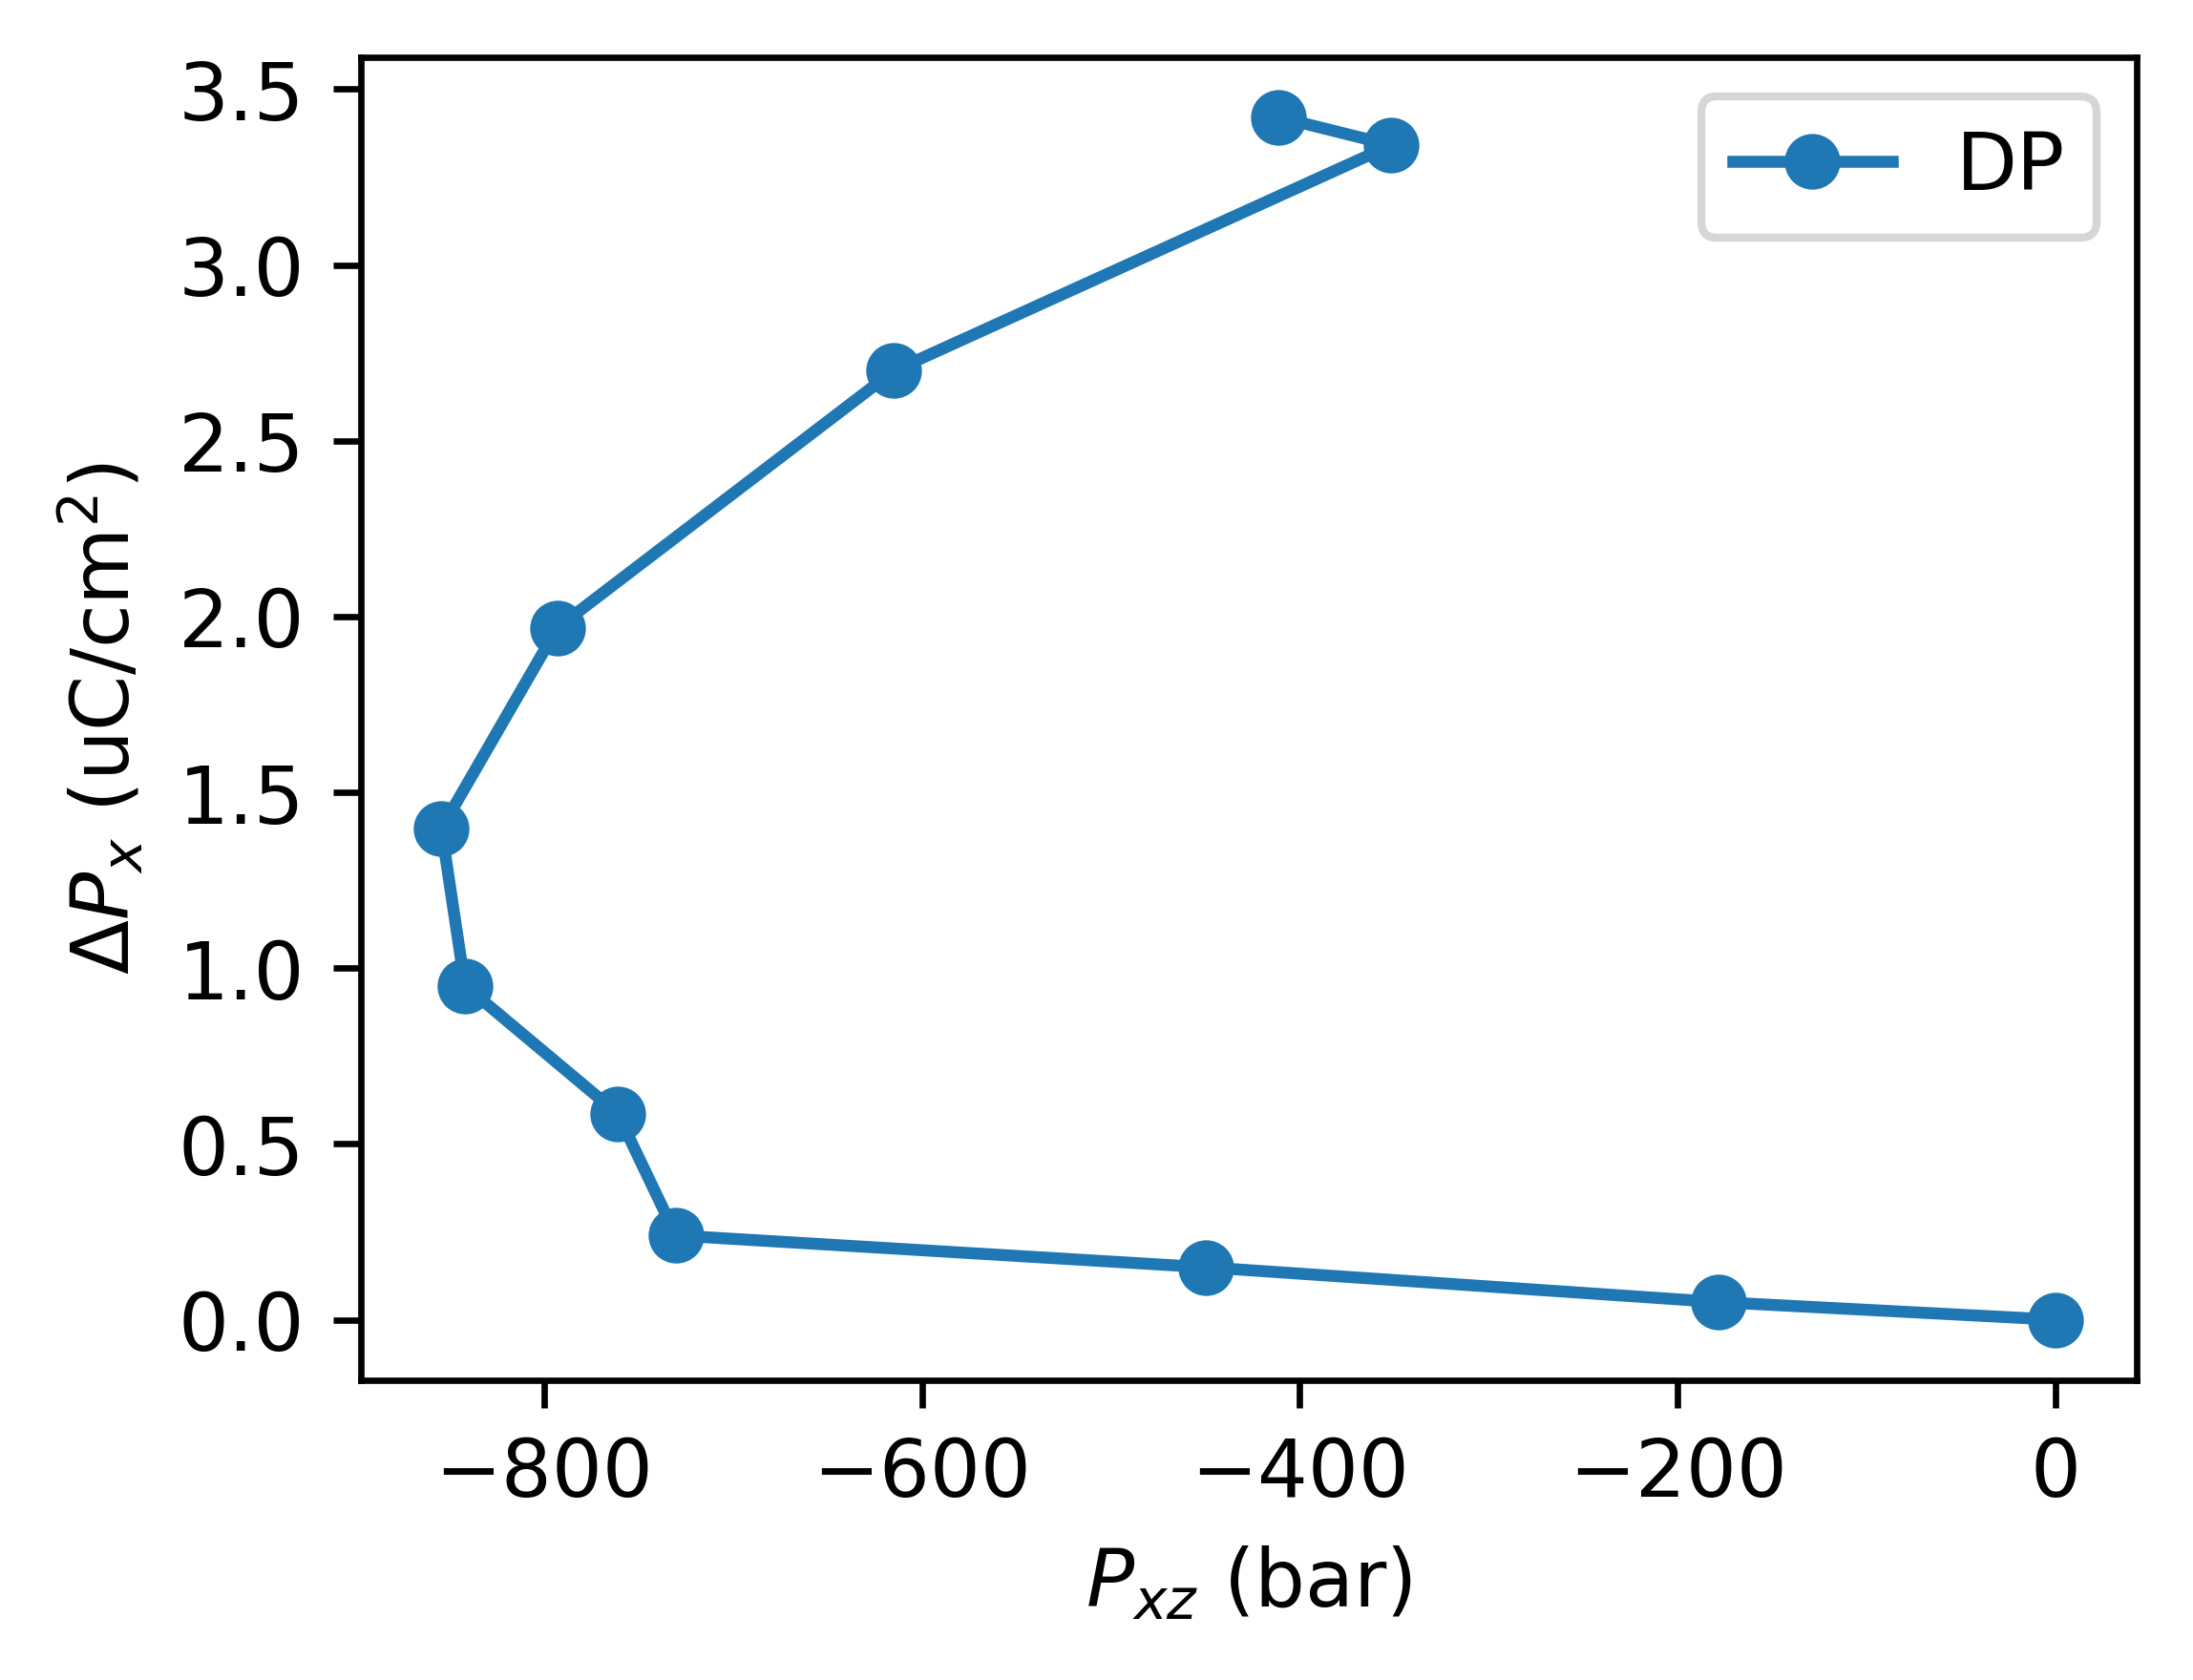

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=600)

ax.plot(mean_Pxz, mean_dp_P[:, 0] - mean_dp_P[0,0], 'o-', label='DP')
ax.legend()
ax.set_xlabel("$P_{xz}$ (bar)")
ax.set_ylabel("$\Delta P_x$ (uC/cm$^2$)")